In [183]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# load libraries

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import numpy as np                                       
import matplotlib.pyplot as plt
from scipy import fft                                    
import h5py

# load training data

In [186]:
train_eeg1path = "train_eeg1.csv"
train_eeg2path = "train_eeg2.csv"
train_emgpath = "train_emg.csv"

label_path = "train_labels.csv"

df_eeg1 = pd.read_csv(train_eeg1path)
df_eeg2 = pd.read_csv(train_eeg2path)
df_emg = pd.read_csv(train_emgpath)

eeg1_data = df_eeg1.values
eeg2_data = df_eeg2.values
emg_data = df_emg.values

eeg1_data = eeg1_data[:,1:]
eeg2_data = eeg2_data[:,1:]
emg_data = emg_data[:,1:]

df_labels = pd.read_csv(label_path)

labels = df_labels.values
labels = labels[:,1]

FileNotFoundError: [Errno 2] File b'train_labels.csv' does not exist: b'train_labels.csv'

training data:
-3 subjects
-for each subject 21'600 epochs à 4 seconds to train

In [3]:
print("EEG1",eeg1_data.shape)
print("EEG2",eeg2_data.shape)
print("EMG",emg_data.shape)

NameError: name 'eeg1_data' is not defined

# load test data

In [2]:
test_eeg1path = "test_eeg1.csv"
test_eeg2path = "test_eeg2.csv"
test_emgpath = "test_emg.csv"

sample_path = "sample.csv"


test_eeg1 = pd.read_csv(test_eeg1path)
test_eeg2 = pd.read_csv(test_eeg2path)
test_emg = pd.read_csv(test_emgpath)

eeg1_test = test_eeg1.values
eeg2_test = test_eeg2.values
emg_test = test_emg.values

eeg1_test = eeg1_test[:,1:]
eeg2_test = eeg2_test[:,1:]
emg_test = emg_test[:,1:]

In [4]:
print(eeg1_test.shape)
print(eeg2_test.shape)
print(emg_test.shape)

(43200, 512)
(43200, 512)
(43200, 512)


# count number of labels per class

In [4]:
def class_counts(lables):
    unique, counts = np.unique(labels,return_counts=True)
    class_counts = dict(zip(unique,counts))
    print(class_counts)
    return class_counts

class_counts(labels)

{1: 34114, 2: 27133, 3: 3553}


{1: 34114, 2: 27133, 3: 3553}

# confusion matrix code

In [10]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# data preprocessing

prepare data to form the input for the CNN

transformations are performed per subject and are meant to diminish non-informative differences in subject specific spectral patterns

each sample has 512 values corresponding to 4x128, where 4 is the number of seconds per epoch

(a) raw signals seperately transformed into spectogram, via a sequence of short Fourier transforms applied to overlapping Hamming windows

(b) EEG signals: band-pass filtered (0.5-24Hz), log transformed

(b) EMG signal: power is integrated over frequency range (0.5-30Hz)(sum up the rows in our time frequency representation within the given frequency range), then one-dimensional signal is repeated multiple times, to get same 2-dimensional representation as for the EEG signals

(c) and standardized per frequency component (zero mean, unit variance)

In [190]:
def make_spectrogram_per_subject(data,window_size = 256, stride=16, sampling_frequency= 128, nperseg = 256,
                                num_frequencies=24):
    num_overlap = nperseg - stride

    f, t, sxx = spectrogram(x=data,fs=sampling_frequency,nperseg=nperseg,
                            window=signal.windows.hamming(nperseg, sym=False),noverlap=num_overlap)
    print(sxx.shape)
    return np.log(sxx)[1:1+num_frequencies,:] # log-transformation of signal 
    

In [191]:
def save_spectrogram_per_epoch(spectrogram,standardize=True, num_epochs =21600, num_frequencies = 24,
                               points_per_epoch = 512, stride=16):
    num_windows_epoch = int(points_per_epoch/stride)
    
    if (standardize):
        rows,cols = spectrogram.shape
        for i in range(rows):
            mean=np.mean(spectrogram,axis=1)
            std=np.std(spectrogram,axis=1)
            r,c = spectrogram.shape
            for rows in range(r):
                for cols in range(c):
                        spectrogram[rows,cols] = (spectrogram[rows,cols]-mean[rows]) / std[rows]

    
    preprocessed = np.zeros((num_epochs,num_frequencies,num_windows_epoch))
    for i in range(num_epochs-1):
        preprocessed[i] = spectrogram[:,i*num_windows_epoch:(i+1)*num_windows_epoch]

    preprocessed[num_epochs-1,0:24,0:17]=spectrogram[0:24,(num_epochs - 1)*num_windows_epoch:]
    
    return preprocessed
    

# training data

## EEG1 signal

In [193]:
for i in range(3):
    eeg1_data_one_dimensional= np.reshape(eeg1_data[i*21600:(i+1)*21600,0:512],-1)
    print(eeg1_data_one_dimensional.shape)
    
    spectrogram_eeg1 = make_spectrogram_per_subject(eeg1_data_one_dimensional)
    spectrogram_eeg1_epoch = save_spectrogram_per_epoch(spectrogram_eeg1)
    file_name = 'extracted_features_eeg1_'+str(i)+'.h5'
    hf1 = h5py.File(file_name, 'w')
    hf1.create_dataset('data', data=spectrogram_eeg1_epoch)
    hf1.close()

(11059200,)
(129, 691185)


KeyboardInterrupt: 

## EEG2 signal

In [18]:
for i in range(3):
    eeg2_data_one_dimensional= np.reshape(eeg2_data[i*21600:(i+1)*21600,0:512],-1)
    print(eeg2_data_one_dimensional.shape)
    
    spectrogram_eeg2 = make_spectrogram_per_subject(eeg2_data_one_dimensional)
    spectrogram_eeg2_epoch = save_spectrogram_per_epoch(spectrogram_eeg2)
    file_name = 'extracted_features_eeg2_'+str(i)+'.h5'
    hf2 = h5py.File(file_name, 'w')
    hf2.create_dataset('data', data=spectrogram_eeg2_epoch)
    hf2.close()

(11059200,)
(129, 691185)
(11059200,)
(129, 691185)
(11059200,)
(129, 691185)


## EMG signal

In [6]:
for i in range(3):
    emg_data_one_dimensional= np.reshape(emg_data[i*21600:(i+1)*21600,0:512],-1)
    print(emg_data_one_dimensional.shape)
    
    spectrogram_emg = make_spectrogram_per_subject(emg_data_one_dimensional,num_frequencies=30)
    
    spectrogram_emg_sum_one_dimensional = np.sum(spectrogram_emg,axis=0)
    print(spectrogram_emg_sum_one_dimensional.shape)

    
    spectrogram_emg_sum_one_dimensional = np.tile(spectrogram_emg_sum_one_dimensional,(24,1))
    print(spectrogram_emg_sum_one_dimensional.shape)
    
    spectrogram_emg_epoch = save_spectrogram_per_epoch(spectrogram_emg_sum_one_dimensional)
    
   
    
    file_name = 'extracted_features_emg_'+str(i)+'.h5'
    hfemg = h5py.File(file_name, 'w')
    hfemg.create_dataset('data', data=spectrogram_emg_epoch)
    hfemg.close()

(11059200,)
(129, 691185)
(691185,)
(24, 691185)
(11059200,)
(129, 691185)
(691185,)
(24, 691185)
(11059200,)
(129, 691185)
(691185,)
(24, 691185)


# test data

## EEG1

In [9]:
for i in range(2):
    eeg1_data_one_dimensional= np.reshape(eeg1_test[i*21600:(i+1)*21600,0:512],-1)
    print(eeg1_data_one_dimensional.shape)
    
    spectrogram_eeg1 = make_spectrogram_per_subject(eeg1_data_one_dimensional)
    spectrogram_eeg1_epoch = save_spectrogram_per_epoch(spectrogram_eeg1)
    file_name = 'extracted_features_eeg1_'+str(i)+'_test.h5'
    hf1 = h5py.File(file_name, 'w')
    hf1.create_dataset('data', data=spectrogram_eeg1_epoch)
    hf1.close()

(11059200,)
(129, 691185)
(11059200,)
(129, 691185)


## EEG2

In [10]:
for i in range(2):
    eeg2_data_one_dimensional= np.reshape(eeg2_test[i*21600:(i+1)*21600,0:512],-1)
    print(eeg2_data_one_dimensional.shape)
    
    spectrogram_eeg2 = make_spectrogram_per_subject(eeg2_data_one_dimensional)
    spectrogram_eeg2_epoch = save_spectrogram_per_epoch(spectrogram_eeg2)
    file_name = 'extracted_features_eeg2_'+str(i)+'_test.h5'
    hf2 = h5py.File(file_name, 'w')
    hf2.create_dataset('data', data=spectrogram_eeg2_epoch)
    hf2.close()

(11059200,)
(129, 691185)
(11059200,)
(129, 691185)


## EMG

In [11]:
for i in range(2):
    emg_data_one_dimensional= np.reshape(emg_test[i*21600:(i+1)*21600,0:512],-1)
    print(emg_data_one_dimensional.shape)
    
    spectrogram_emg = make_spectrogram_per_subject(emg_data_one_dimensional,num_frequencies=30)
    
    spectrogram_emg_sum_one_dimensional = np.sum(spectrogram_emg,axis=0)
    print(spectrogram_emg_sum_one_dimensional.shape)

    
    spectrogram_emg_sum_one_dimensional = np.tile(spectrogram_emg_sum_one_dimensional,(24,1))
    print(spectrogram_emg_sum_one_dimensional.shape)
    
    spectrogram_emg_epoch = save_spectrogram_per_epoch(spectrogram_emg_sum_one_dimensional)
    
   
    
    file_name = 'extracted_features_emg_'+str(i)+'_test.h5'
    hfemg = h5py.File(file_name, 'w')
    hfemg.create_dataset('data', data=spectrogram_emg_epoch)
    hfemg.close()

(11059200,)
(129, 691185)
(691185,)
(24, 691185)
(11059200,)
(129, 691185)
(691185,)
(24, 691185)


# read from saved data

In [3]:
import h5py
hfr = h5py.File('extracted_features_eeg1_0.h5', 'r')

In [4]:
hfr.keys()


KeysView(<HDF5 file "extracted_features_eeg1_0.h5" (mode r)>)

In [5]:
n1 = hfr.get('data')

In [6]:
import numpy as np
n1 = np.array(n1)
n1.shape

(21600, 24, 32)

Text(0,0.5,'frequency')

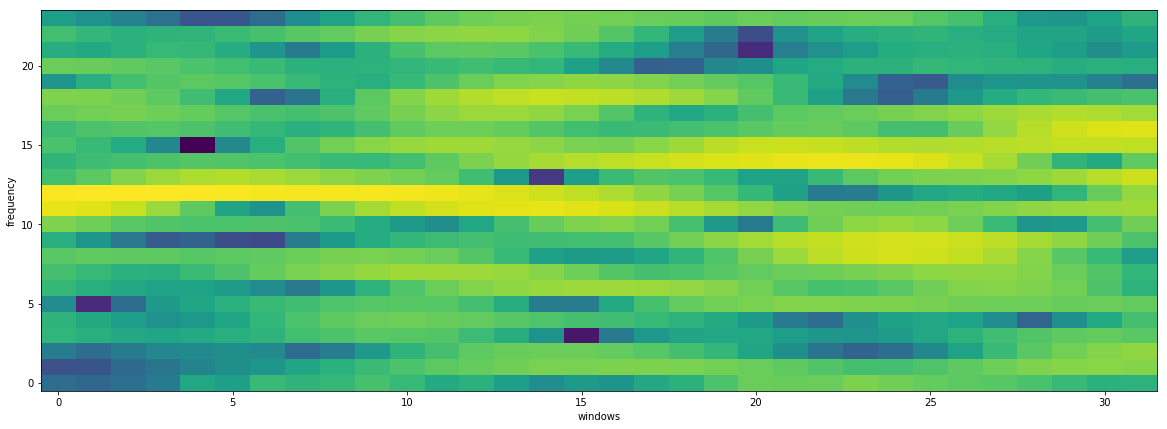

In [7]:
fig = plt.figure(figsize=(20,7))
plt.imshow(n1[0],aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('windows')
fig.axes[0].set_ylabel('frequency')

# DNN paper

## load input data

In [7]:
import h5py

def make_training_data_for_subject(subject,training_or_test='training'):
    
    file_name_eeg1 = 'extracted_features_eeg1_'
    file_name_eeg2 = 'extracted_features_eeg2_'
    file_name_emg = 'extracted_features_emg_'
    
    if(training_or_test in ['training']):
        hf_eeg1 = h5py.File(file_name_eeg1 + str(subject) + '.h5', 'r')
        data_eeg1 = np.array(hf_eeg1.get('data'))
        
        hf_eeg2 = h5py.File(file_name_eeg2 + str(subject) + '.h5', 'r')
        data_eeg2 = np.array(hf_eeg2.get('data'))
        
        hf_emg = h5py.File(file_name_emg + str(subject) + '.h5', 'r')
        data_emg = np.array(hf_emg.get('data'))
    else:
        hf_eeg1 = h5py.File(file_name_eeg1 + str(subject) + '_test.h5', 'r')
        data_eeg1 = np.array(hf_eeg1.get('data'))
        
        hf_eeg2 = h5py.File(file_name_eeg2 + str(subject) + '_test.h5', 'r')
        data_eeg2 = np.array(hf_eeg2.get('data'))
        
        hf_emg = h5py.File(file_name_emg + str(subject) + '_test.h5', 'r')
        data_emg = np.array(hf_emg.get('data'))
        
     
    num_subjects, height, breadth = data_eeg1.shape
    
    data_input = np.zeros((num_subjects,3,height,5*breadth)) 
    
    
    for i in [0]:
        data_input[i,0,:,0:breadth] = data_eeg1[i].copy()
        data_input[i,0,:,breadth:2*breadth] = data_eeg1[i].copy()
        data_input[i,0,:,2*breadth:3*breadth] = data_eeg1[i].copy()
        data_input[i,0,:,3*breadth:4*breadth] = data_eeg1[i+1].copy()
        data_input[i,0,:,4*breadth:5*breadth] = data_eeg1[i+2].copy()

        data_input[i,1,:,0:breadth] = data_eeg2[i].copy()
        data_input[i,1,:,breadth:2*breadth] = data_eeg2[i].copy()
        data_input[i,1,:,2*breadth:3*breadth] = data_eeg2[i].copy()
        data_input[i,1,:,3*breadth:4*breadth] = data_eeg2[i+1].copy()
        data_input[i,1,:,4*breadth:5*breadth] = data_eeg2[i+2].copy()

        data_input[i,2,:,0:breadth] = data_emg[i].copy()
        data_input[i,2,:,breadth:2*breadth] = data_emg[i].copy()
        data_input[i,2,:,2*breadth:3*breadth] = data_emg[i].copy()
        data_input[i,2,:,3*breadth:4*breadth] = data_emg[i+1].copy()
        data_input[i,2,:,4*breadth:5*breadth] = data_emg[i+2].copy()
        
    
    for i in [1]:
        data_input[i,0,:,0:breadth] = data_eeg1[i-1].copy()
        data_input[i,0,:,breadth:2*breadth] = data_eeg1[i-1].copy()
        data_input[i,0,:,2*breadth:3*breadth] = data_eeg1[i].copy()
        data_input[i,0,:,3*breadth:4*breadth] = data_eeg1[i+1].copy()
        data_input[i,0,:,4*breadth:5*breadth] = data_eeg1[i+2].copy()

        data_input[i,1,:,0:breadth] = data_eeg2[i-1].copy()
        data_input[i,1,:,breadth:2*breadth] = data_eeg2[i-1].copy()
        data_input[i,1,:,2*breadth:3*breadth] = data_eeg2[i].copy()
        data_input[i,1,:,3*breadth:4*breadth] = data_eeg2[i+1].copy()
        data_input[i,1,:,4*breadth:5*breadth] = data_eeg2[i+2].copy()

        data_input[i,2,:,0:breadth] = data_emg[i-1].copy()
        data_input[i,2,:,breadth:2*breadth] = data_emg[i-1].copy()
        data_input[i,2,:,2*breadth:3*breadth] = data_emg[i].copy()
        data_input[i,2,:,3*breadth:4*breadth] = data_emg[i+1].copy()
        data_input[i,2,:,4*breadth:5*breadth] = data_emg[i+2].copy()
    
    for i in range(2,num_subjects-2):
        data_input[i,0,:,0:breadth] = data_eeg1[i-2].copy()
        data_input[i,0,:,breadth:2*breadth] = data_eeg1[i-1].copy()
        data_input[i,0,:,2*breadth:3*breadth] = data_eeg1[i].copy()
        data_input[i,0,:,3*breadth:4*breadth] = data_eeg1[i+1].copy()
        data_input[i,0,:,4*breadth:5*breadth] = data_eeg1[i+2].copy()
        
        data_input[i,1,:,0:breadth] = data_eeg2[i-2].copy()
        data_input[i,1,:,breadth:2*breadth] = data_eeg2[i-1].copy()
        data_input[i,1,:,2*breadth:3*breadth] = data_eeg2[i].copy()
        data_input[i,1,:,3*breadth:4*breadth] = data_eeg2[i+1].copy()
        data_input[i,1,:,4*breadth:5*breadth] = data_eeg2[i+2].copy()
        
        data_input[i,2,:,0:breadth] = data_emg[i-2].copy()
        data_input[i,2,:,breadth:2*breadth] = data_emg[i-1].copy()
        data_input[i,2,:,2*breadth:3*breadth] = data_emg[i].copy()
        data_input[i,2,:,3*breadth:4*breadth] = data_emg[i+1].copy()
        data_input[i,2,:,4*breadth:5*breadth] = data_emg[i+2].copy()
    
    for i in [num_subjects-2]:
        data_input[i,0,:,0:breadth] = data_eeg1[i-2].copy()
        data_input[i,0,:,breadth:2*breadth] = data_eeg1[i-1].copy()
        data_input[i,0,:,2*breadth:3*breadth] = data_eeg1[i].copy()
        data_input[i,0,:,3*breadth:4*breadth] = data_eeg1[i+1].copy()
        data_input[i,0,:,4*breadth:5*breadth] = data_eeg1[i+1].copy()
        
        data_input[i,1,:,0:breadth] = data_eeg2[i-2].copy()
        data_input[i,1,:,breadth:2*breadth] = data_eeg2[i-1].copy()
        data_input[i,1,:,2*breadth:3*breadth] = data_eeg2[i].copy()
        data_input[i,1,:,3*breadth:4*breadth] = data_eeg2[i+1].copy()
        data_input[i,1,:,4*breadth:5*breadth] = data_eeg2[i+1].copy()
        
        data_input[i,2,:,0:breadth] = data_emg[i-2].copy()
        data_input[i,2,:,breadth:2*breadth] = data_emg[i-1].copy()
        data_input[i,2,:,2*breadth:3*breadth] = data_emg[i].copy()
        data_input[i,2,:,3*breadth:4*breadth] = data_emg[i+1].copy()
        data_input[i,2,:,4*breadth:5*breadth] = data_emg[i+1].copy()

    for i in [num_subjects-1]:
        data_input[i,0,:,0:breadth] = data_eeg1[i-2].copy()
        data_input[i,0,:,breadth:2*breadth] = data_eeg1[i-1].copy()
        data_input[i,0,:,2*breadth:3*breadth] = data_eeg1[i].copy()
        data_input[i,0,:,3*breadth:4*breadth] = data_eeg1[i].copy()
        data_input[i,0,:,4*breadth:5*breadth] = data_eeg1[i].copy()
        
        data_input[i,1,:,0:breadth] = data_eeg2[i-2].copy()
        data_input[i,1,:,breadth:2*breadth] = data_eeg2[i-1].copy()
        data_input[i,1,:,2*breadth:3*breadth] = data_eeg2[i].copy()
        data_input[i,1,:,3*breadth:4*breadth] = data_eeg2[i].copy()
        data_input[i,1,:,4*breadth:5*breadth] = data_eeg2[i].copy()
        
        data_input[i,2,:,0:breadth] = data_emg[i-2].copy()
        data_input[i,2,:,breadth:2*breadth] = data_emg[i-1].copy()
        data_input[i,2,:,2*breadth:2*breadth+16] = data_emg[i,:,0:16].copy()
        data_input[i,2,:,2*breadth+16:3*breadth] = data_emg[i,:,0:16].copy()
        data_input[i,2,:,3*breadth:4*breadth] = data_emg[i-1].copy()
        data_input[i,2,:,4*breadth:5*breadth] = data_emg[i-1].copy()
        
    return data_input
    

In [8]:
training_data_0 = make_training_data_for_subject(subject=0,training_or_test='training')


In [9]:
training_data_1 = make_training_data_for_subject(subject=1,training_or_test='training')


(21600, 3, 24, 160)


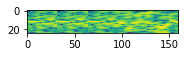

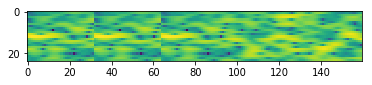

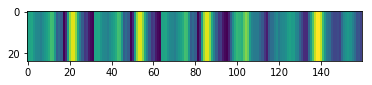

/home/matthias/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


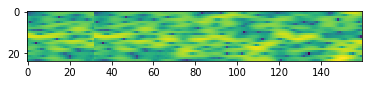

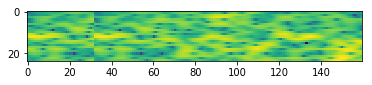

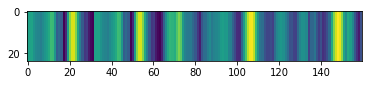

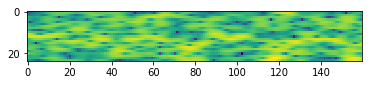

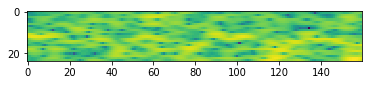

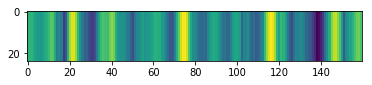

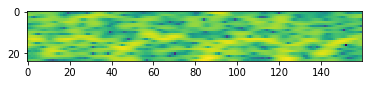

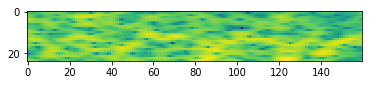

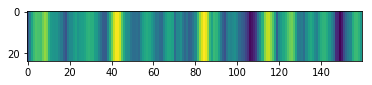

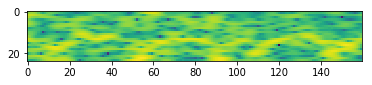

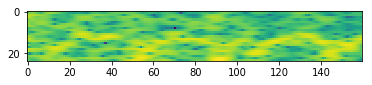

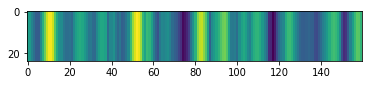

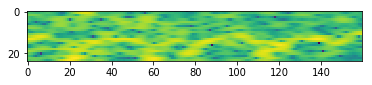

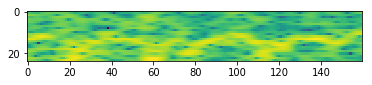

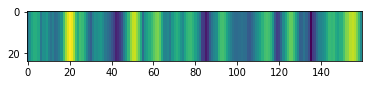

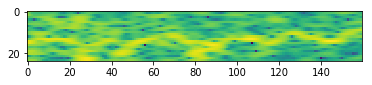

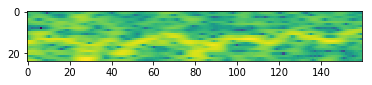

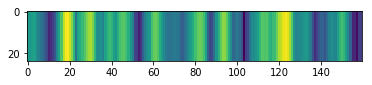

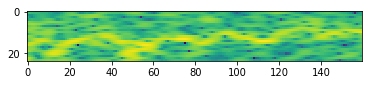

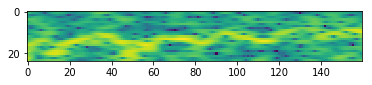

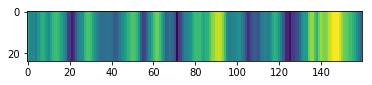

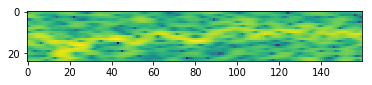

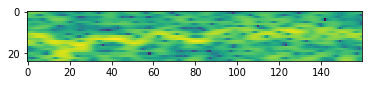

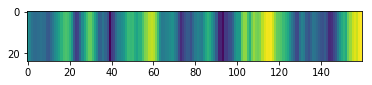

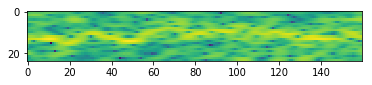

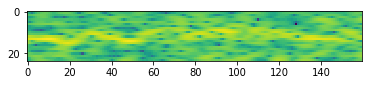

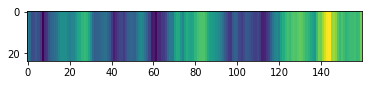

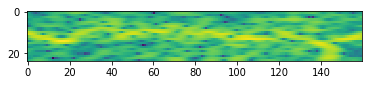

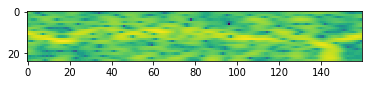

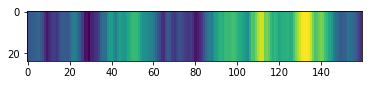

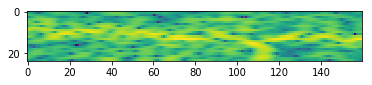

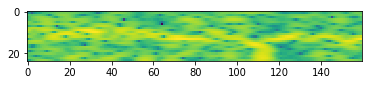

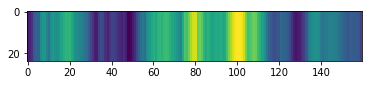

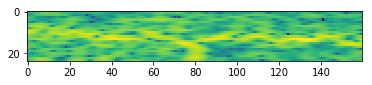

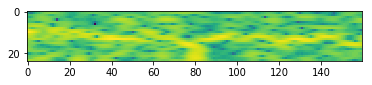

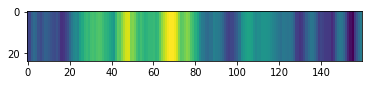

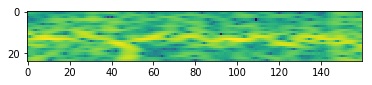

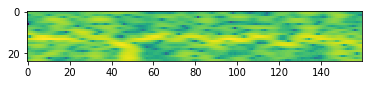

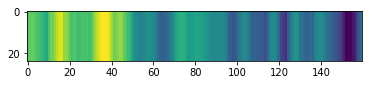

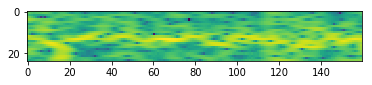

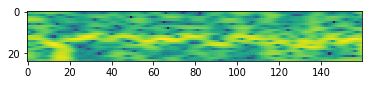

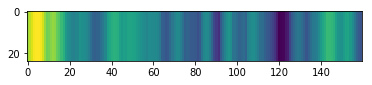

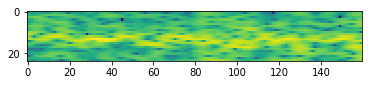

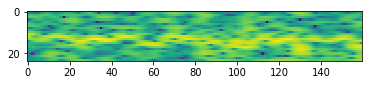

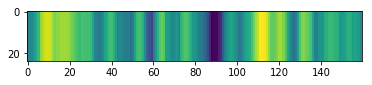

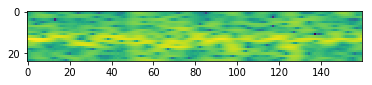

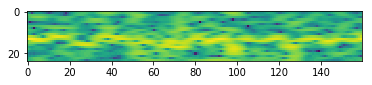

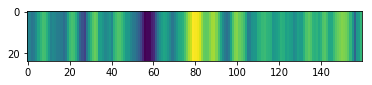

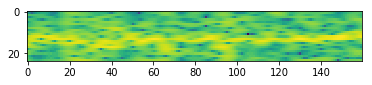

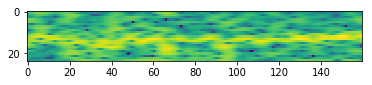

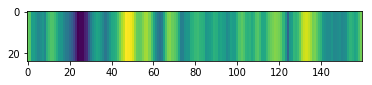

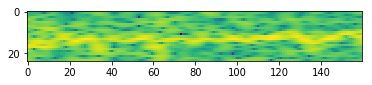

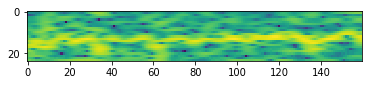

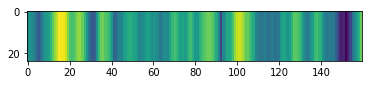

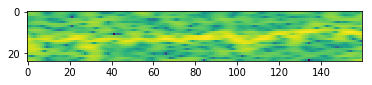

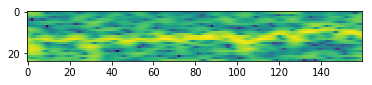

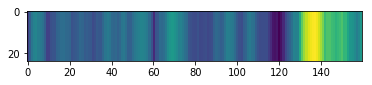

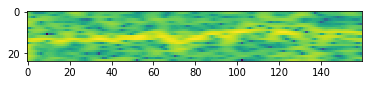

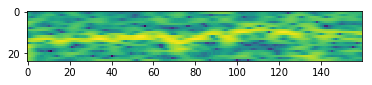

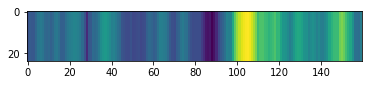

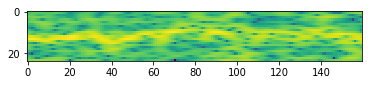

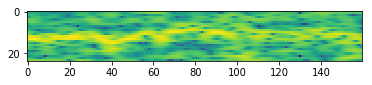

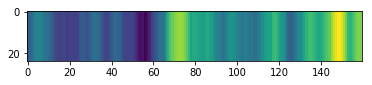

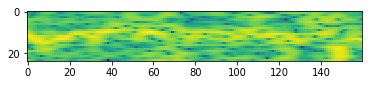

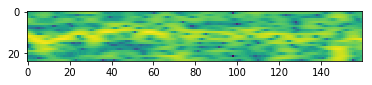

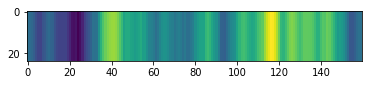

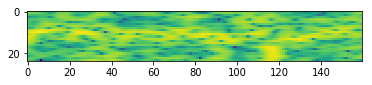

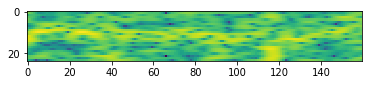

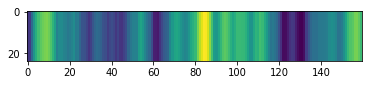

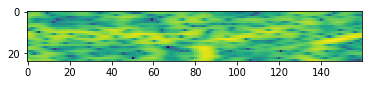

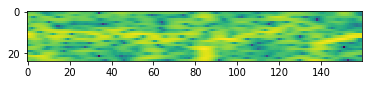

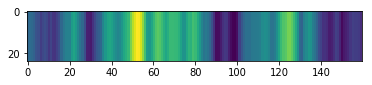

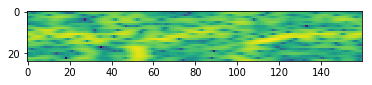

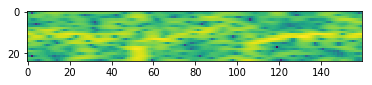

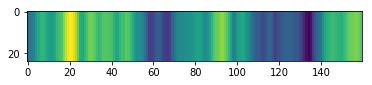

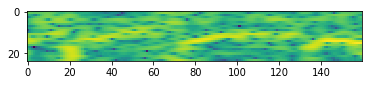

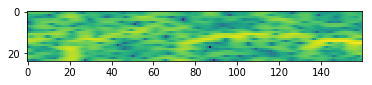

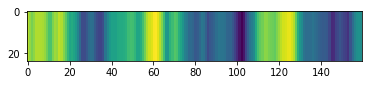

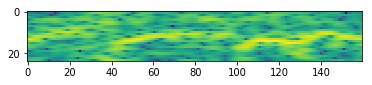

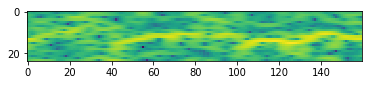

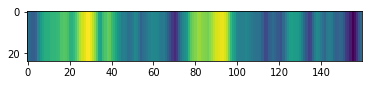

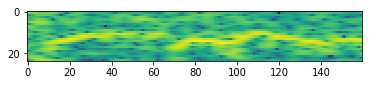

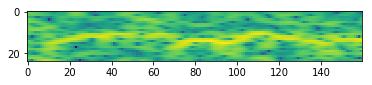

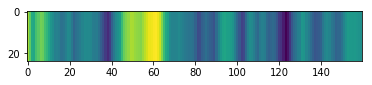

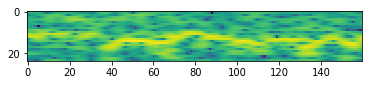

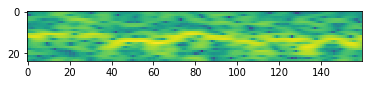

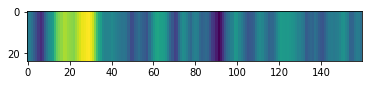

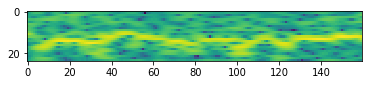

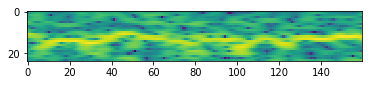

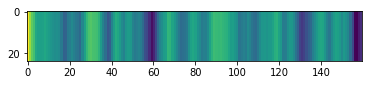

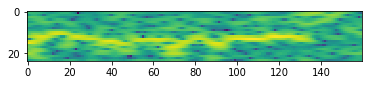

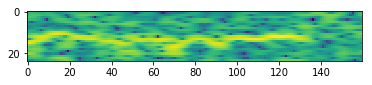

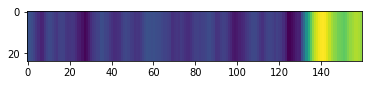

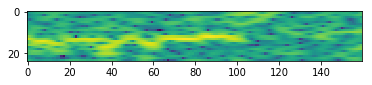

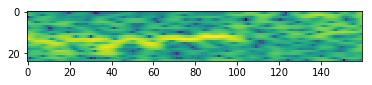

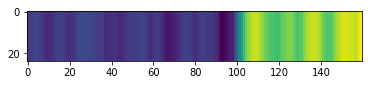

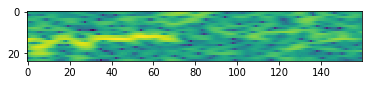

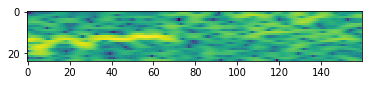

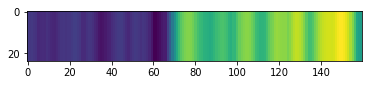

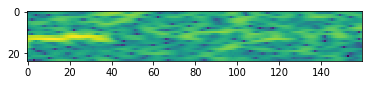

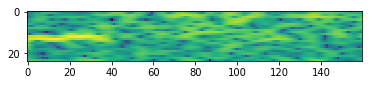

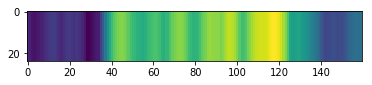

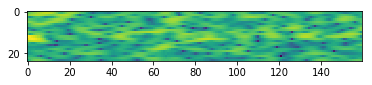

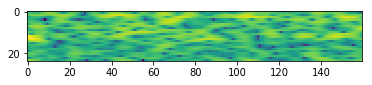

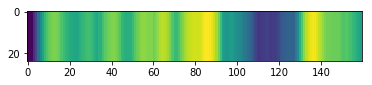

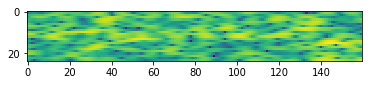

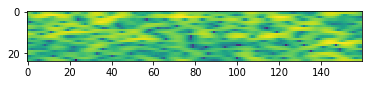

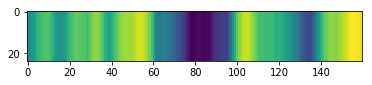

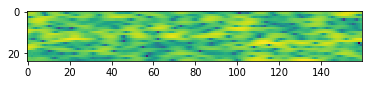

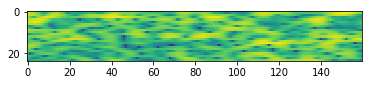

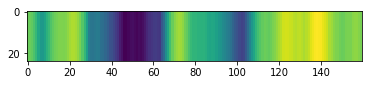

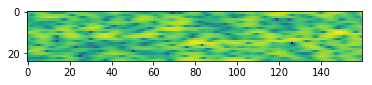

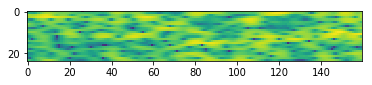

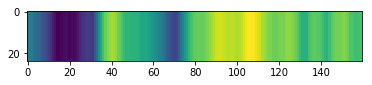

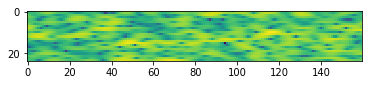

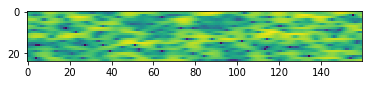

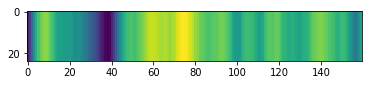

In [18]:
import numpy as np
import matplotlib.pyplot as plt

w=10
h=10
fig=plt.figure(figsize=(50, 20))
columns = 1
rows = 40
for j in range(rows):
    for i in range(0, 3):
        #img = training_data_0[i,0,:,32:160]-training_data_0[i+1,0,:,0:128]
        img = training_data_0[j,i]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img)
        plt.show()

# CNN model

In [19]:
# from here onwards -preliminary code

## load libraries for CNN

In [4]:
import keras
import numpy as np
import tensorflow as tf
import random as rn
import pandas as pd
 
import keras
from keras import backend as K
from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPooling2D,Conv2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# for CNNs
# from keras.layers import Conv2D, MaxPooling2D
 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [120]:
# parameters
batch_size = 100


In [122]:
# starting to build their setup
def make_CNN():
    model = Sequential()

    model.add( MaxPooling2D(pool_size=(3, 2), strides=(3,2), padding='valid', data_format=None) )

    model.add(Conv2D(filters=50, kernel_size=(3,3), strides=(1, 1), padding='valid', data_format=None,
                     dilation_rate=(1, 1), activation='relu', use_bias=True,
                     kernel_initializer='he_uniform', bias_initializer='zeros',
                     kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
                     kernel_constraint=None, bias_constraint=None)
             )

    model.add( MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='valid', data_format=None) )

    model.add(Dense(1000,
                    activation='relu',
                    kernel_initializer='he_uniform' ))
    model.add(BatchNormalization(axis=1))
    model.add(Dropout(0.5))

    model.add(Dense(1000,
                    activation='relu',
                    kernel_initializer='he_uniform' ))
    model.add(BatchNormalization(axis=1))
    model.add(Dropout(0.5))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # TODO: The weight decay rates of first and second moment were set to 0.9 and 0.99
    # TODO: cost-sensitve loss as in paper
    return model

In [123]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
model.fit(X_train, y_train, class_weight=class_weights)


NameError: name 'y_train' is not defined